# $NicheVI-workflow$

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch

import anndata as ad
import numpy as np
import pandas as pd

from rich import print
import os

import scvi

import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc

from scib_metrics.benchmark import Benchmarker
from phenospace.results_analysis import spatial_latent_analysis, SpatialAnalysis

/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/

In [3]:
scvi.settings.seed = 34

Global seed set to 34


In [4]:
!ls /home/nathanlevy/Data/

BrainAgingSpatialAtlas_MERFISH	Liver_VIZGEN


In [5]:
plots = True

In [6]:
data_dir = "/home/nathanlevy/Data/BrainAgingSpatialAtlas_MERFISH/"
data_file = "adata_scvi_merfish4w.h5ad"
data_file_name = os.path.splitext(data_file)[0]
print(data_file_name)

adata_scvi_merfish4w

In [7]:
path_to_save = os.path.join("checkpoints", data_file_name)
os.makedirs(path_to_save, exist_ok=True)

In [8]:
adata = ad.read_h5ad(data_dir + data_file)
print(adata)

AnnData object with n_obs × n_vars = 123632 × 374
    obs: 'fov', 'center_x', 'center_y', 'min_x', 'max_x', 'min_y', 'max_y', 'age', 'clust_annot', 'slice', 
'organism_ontology_term_id', 'sex_ontology_term_id', 'suspension_type', 'cell_type_ontology_term_id', 
'assay_ontology_term_id', 'tissue_ontology_term_id', 'disease_ontology_term_id', 
'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'donor_id', 'is_primary_data', 
'cell_type_annot', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 
'development_stage', 'donor_slice', 'n_counts', 'cell_index', '_scvi_batch', '_scvi_labels'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'cell_type_colors', 'donor_id_colors', 'log1p', 'neighbors', 'pca', 
'umap'
    obsm: 'X_pca', 'X_scVI', 'X_spVI', 'X_spatial', 'X_umap', 'centroids', 'neighborhood_composition', 'spatial'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [13]:
# adata.obs.clust_annot.value_counts()

In [14]:
# for sample in adata.obs.donor_slice.unique().tolist()[:3]:

#     sc.pl.spatial(adata[adata.obs.donor_slice==sample], spot_size=40, color='cell_type', title=sample)

## First train (linear)scVI

In [18]:
lvae_is_trained = True
save_lvae = True

if lvae_is_trained:
    vae = scvi.model.LinearSCVI.load(dir_path=path_to_save + "/lvae.pt", adata=adata)

if lvae_is_trained == False:
    scvi.model.LinearSCVI.setup_anndata(
        adata,
        layer="counts",
        batch_key="donor_id",
    )

    vae = scvi.model.LinearSCVI(
        adata,
        gene_likelihood="poisson",
        n_layers=1,
        n_latent=10,
    )

    vae.train(
        max_epochs=40,
        train_size=0.8,
        validation_size=0.2,
        plan_kwargs=dict(n_epochs_kl_warmup=80),
        early_stopping=True,
    )

    if save_lvae:
        vae.save(dir_path=path_to_save + "/lvae.pt", save_anndata=False)

INFO     File checkpoints/adata_scvi_merfish4w/lvae.pt/model.pt already downloaded                                 


In [19]:
adata.obsm["qz1_m"], adata.obsm["qz1_var"] = vae.get_latent_representation(
    return_dist=True
)

/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


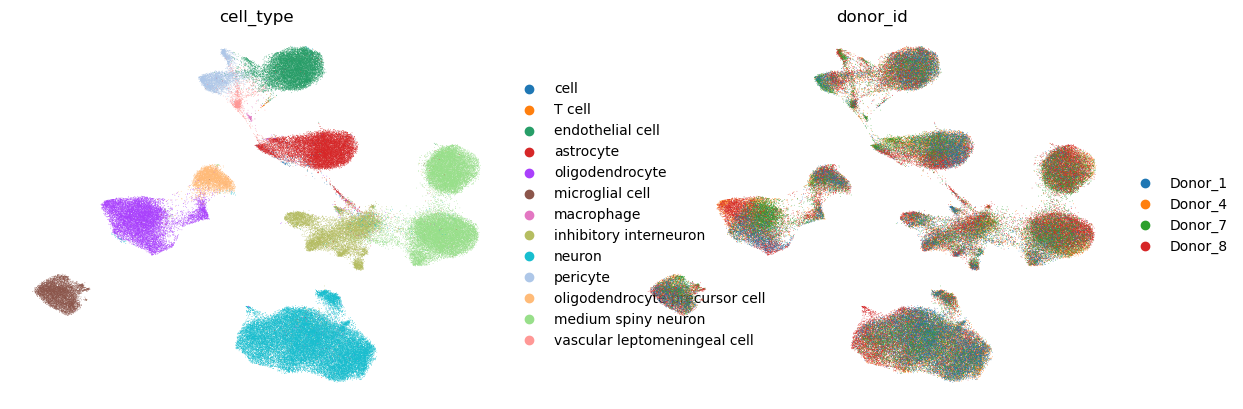

In [18]:
if plots:
    sc.pp.neighbors(adata, use_rep="qz1_m")
    sc.tl.umap(adata, min_dist=0.3)

    sc.pl.umap(
        adata,
        color=["cell_type", "donor_id"],
        ncols=2,
        frameon=False,
    )

In [20]:
vae.history.keys()

dict_keys(['kl_weight', 'train_loss_step', 'validation_loss', 'elbo_validation', 'reconstruction_loss_validation', 'kl_local_validation', 'kl_global_validation', 'train_loss_epoch', 'elbo_train', 'reconstruction_loss_train', 'kl_local_train', 'kl_global_train'])

<Axes: xlabel='epoch'>

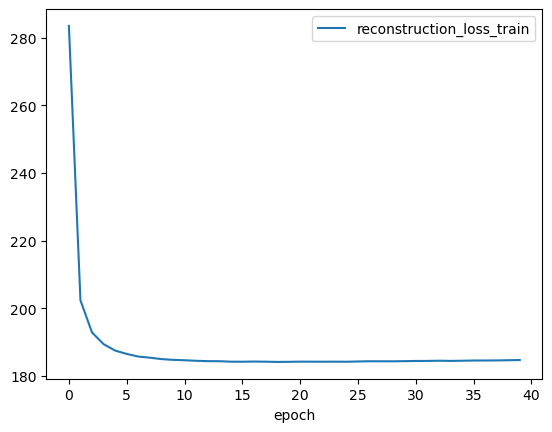

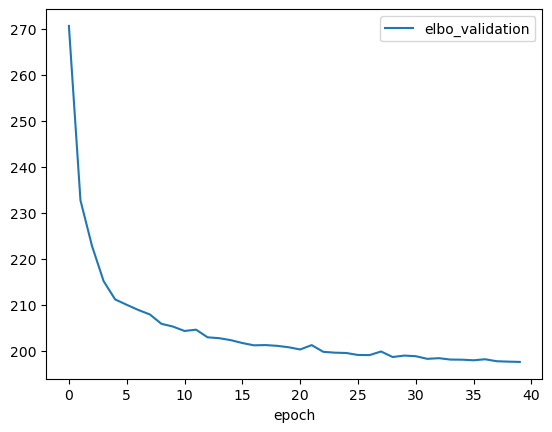

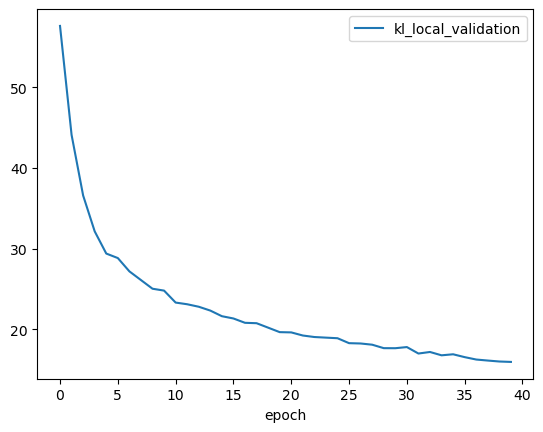

In [21]:
vae.history["reconstruction_loss_train"].plot()
vae.history["elbo_validation"].plot()
vae.history["kl_local_validation"].plot()

In [22]:
is_trained = True
save_scvi = True

if is_trained == False:
    scvi.model.SCVI.setup_anndata(
        adata,
        layer="counts",
        batch_key="donor_id",
    )

    scvivae = scvi.model.SCVI(
        adata,
        gene_likelihood="poisson",
        n_layers=1,
        n_latent=10,
    )

    scvivae.train(
        max_epochs=40,
        train_size=0.8,
        validation_size=0.2,
        plan_kwargs=dict(n_epochs_kl_warmup=80),
        early_stopping=True,
    )

    if save_scvi:
        scvivae.save(dir_path=path_to_save + "/scvivae.pt", save_anndata=False)

if is_trained:
    scvivae = scvi.model.SCVI.load(dir_path=path_to_save + "/scvivae.pt", adata=adata)

adata.obsm["X_scVI"] = scvivae.get_latent_representation()

INFO     File checkpoints/adata_scvi_merfish4w/scvivae.pt/model.pt already downloaded                              


<Axes: xlabel='epoch'>

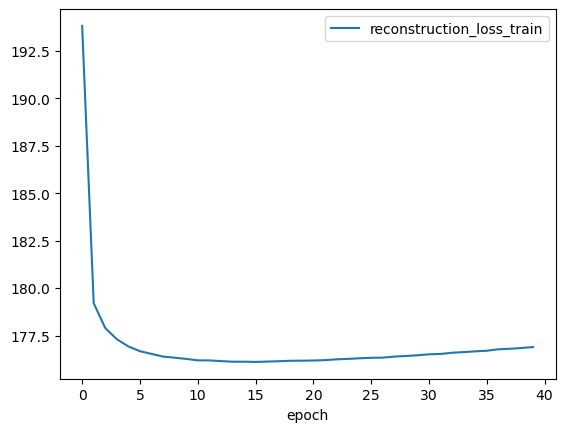

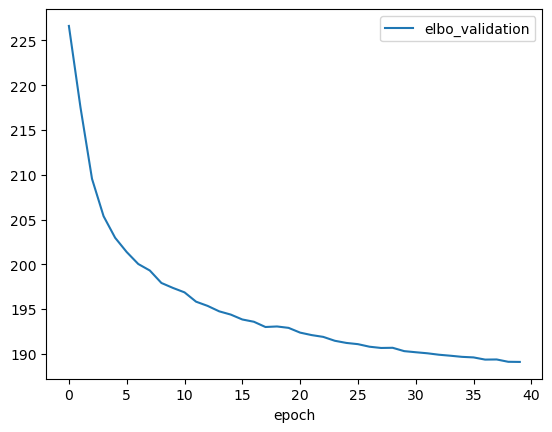

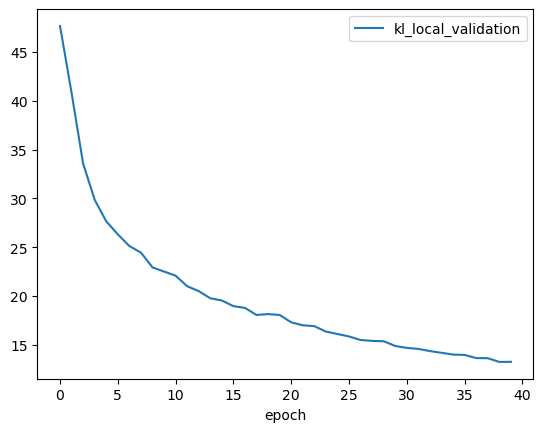

In [23]:
scvivae.history["reconstruction_loss_train"].plot()
scvivae.history["elbo_validation"].plot()
scvivae.history["kl_local_validation"].plot()

## Then train $nicheVI$

Parameters

In [24]:
k_nn = 20
n_latent_z1 = adata.obsm["qz1_var"].shape[1]

In [25]:
print(adata.obsm)

AxisArrays with keys: X_pca, X_scVI, X_spVI, X_spatial, X_umap, centroids, neighborhood_composition, spatial, 
qz1_m, qz1_var

In [26]:
# preprocessing function to populate adata.obsm with the keys 'neighborhood_composition',
# 'qz1_m', 'qz1_var', 'niche_indexes', 'niche_distances', 'qz1_m_niche_knn', 'qz1_var_niche_knn', 'qz1_m_niche_ct',
# 'qz1_var_niche_ct'

scvi.model.nicheSCVI.preprocessing_anndata(
    adata,
    niche_composition_key="neighborhood_composition",
    niche_indexes_key="niche_indexes",
    niche_distances_key="niche_distances",
    label_key="cell_type",
    sample_key="donor_slice",
    cell_coordinates_key="centroids",
    k_nn=k_nn,
    latent_mean_key="qz1_m",
    latent_var_key="qz1_var",
    latent_mean_niche_keys=["qz1_m_niche_ct"],
    latent_var_niche_keys=["qz1_var_niche_ct"],
)

Saved niche_indexes and niche_distances in adata.obsm
Saved niche_composition in adata.obsm


Saved qz1_m_niche_ct and qz1_var_niche_ct in adata.obsm


In [27]:
adata.obsm["qz1_m_niche_ct"].shape

(123632, 13, 10)

In [28]:
print(adata.obsm.keys())

KeysView(AxisArrays with keys: X_pca, X_scVI, X_spVI, X_spatial, X_umap, centroids, neighborhood_composition, 
spatial, qz1_m, qz1_var, niche_indexes, niche_distances, qz1_m_niche_ct, qz1_var_niche_ct)

In [29]:
scvi.model.nicheSCVI.setup_anndata(
    adata,
    layer="counts",
    batch_key="donor_id",
    labels_key="cell_type",
    niche_composition_key="neighborhood_composition",
    niche_indexes_key="niche_indexes",
    niche_distances_key="niche_distances",
    latent_mean_key="qz1_m",
    latent_var_key="qz1_var",
    latent_mean_ct_key="qz1_m_niche_ct",
    latent_var_ct_key="qz1_var_niche_ct",
)

INFO     Using column names from columns of adata.obsm['neighborhood_composition']                                 
INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        


In [35]:
niche_setup = {
    # "cell_type_setup": {
    #     "niche_components": "cell_type",
    #     "niche_combination": "aggregate",
    #     "z1_mean": adata.obsm["qz1_m_niche_ct"],
    #     "z1_var": adata.obsm["qz1_var_niche_ct"],
    # },
    # "knn_setup": {
    #     "niche_components": "knn",
    #     "niche_combination": "aggregate",
    #     "z1_mean": adata.obsm["qz1_m_niche_knn"],
    #     "z1_var": adata.obsm["qz1_var_niche_knn"],
    # },
    # "knn_unweighted_setup": {
    #     "niche_components": "knn_unweighted",
    #     "niche_combination": "aggregate",
    #     "z1_mean": adata.obsm["qz1_m_niche_knn"],
    #     "z1_var": adata.obsm["qz1_var_niche_knn"],
    # },
    # "cell_type_unweighted_setup": {
    #     "niche_components": "cell_type_unweighted",
    #     "niche_combination": "aggregate",
    #     "z1_mean": adata.obsm["qz1_m_niche_ct"],
    #     "z1_var": adata.obsm["qz1_var_niche_ct"],
    # },
    "mix_kl0_compo0": {
        "niche_components": "cell_type",
        "niche_combination": "mixture",
        "elbo_weight": 1,
        "niche_kl_weight": 0,
        "niche_compo_weight": 0,
    },
    "mix_unif_kl0_compo0": {
        "niche_components": "cell_type_unweighted",
        "niche_combination": "mixture",
        "elbo_weight": 1,
        "niche_kl_weight": 0,
        "niche_compo_weight": 0,
    },
    "mix_kl1_compo1": {
        "niche_components": "cell_type",
        "niche_combination": "mixture",
        "elbo_weight": 1,
        "niche_kl_weight": 1,
        "niche_compo_weight": 1,
    },
    "mix_unif_kl1_compo1": {
        "niche_components": "cell_type_unweighted",
        "niche_combination": "mixture",
        "elbo_weight": 1,
        "niche_kl_weight": 1,
        "niche_compo_weight": 1,
    },
    "mix_kl10_compo10": {
        "niche_components": "cell_type",
        "niche_combination": "mixture",
        "elbo_weight": 1,
        "niche_kl_weight": 10,
        "niche_compo_weight": 10,
    },
    "mix_unif_kl10_compo10": {
        "niche_components": "cell_type_unweighted",
        "niche_combination": "mixture",
        "elbo_weight": 1,
        "niche_kl_weight": 10,
        "niche_compo_weight": 10,
    },
     "mix_kl50_compo50": {
        "niche_components": "cell_type",
        "niche_combination": "mixture",
        "elbo_weight": 1,
        "niche_kl_weight": 50,
        "niche_compo_weight": 50,
    },
    "mix_unif_kl50_compo50": {
        "niche_components": "cell_type_unweighted",
        "niche_combination": "mixture",
        "elbo_weight": 1,
        "niche_kl_weight": 50,
        "niche_compo_weight": 50,
    },
}

In [36]:
nichevae_is_trained = True
save_pt = True
history_setup = {}

In [38]:
for setup in niche_setup.keys():
    print(setup)
    setup_dict = niche_setup[setup]

    nichevae = scvi.model.nicheSCVI(
        adata,
        elbo_weight=setup_dict["elbo_weight"],       
        niche_kl_weight=setup_dict["niche_kl_weight"],
        niche_compo_weight=setup_dict["niche_compo_weight"],
        niche_components=setup_dict["niche_components"],
        niche_combination=setup_dict["niche_combination"],
        gene_likelihood="poisson",
        n_layers=1,
        n_latent=n_latent_z1,
        use_batch_norm="both",
        use_layer_norm="none",
    )

    if nichevae_is_trained == False:
        nichevae.train(
            max_epochs=40,
            train_size=0.8,
            validation_size=0.2,
            plan_kwargs=dict(n_epochs_kl_warmup=80),
            early_stopping=True,
            batch_size=128,
        )

        if save_pt:
            nichevae.save(
                dir_path=path_to_save + "/nichevae_" + setup + "_.pt",
                save_anndata=False
                # dir_path="./checkpoints/nichevae_" + setup + "_.pt", save_anndata=False
            )

    if nichevae_is_trained:
        nichevae = scvi.model.nicheSCVI.load(
            dir_path=path_to_save + "/nichevae_" + setup + "_.pt", adata=adata
        )

    history_setup[setup] = nichevae.history
    adata.obsm[setup+"_X_nicheVI"] = nichevae.get_latent_representation()

mix_kl0_compo0

INFO     File checkpoints/adata_scvi_merfish4w/nichevae_mix_kl0_compo0_.pt/model.pt already downloaded             


mix_unif_kl0_compo0

INFO     File checkpoints/adata_scvi_merfish4w/nichevae_mix_unif_kl0_compo0_.pt/model.pt already downloaded        


mix_kl1_compo1

INFO     File checkpoints/adata_scvi_merfish4w/nichevae_mix_kl1_compo1_.pt/model.pt already downloaded             


mix_unif_kl1_compo1

INFO     File checkpoints/adata_scvi_merfish4w/nichevae_mix_unif_kl1_compo1_.pt/model.pt already downloaded        


mix_kl10_compo10

INFO     File checkpoints/adata_scvi_merfish4w/nichevae_mix_kl10_compo10_.pt/model.pt already downloaded           


mix_unif_kl10_compo10

INFO     File checkpoints/adata_scvi_merfish4w/nichevae_mix_unif_kl10_compo10_.pt/model.pt already downloaded      


mix_kl50_compo50

INFO     File checkpoints/adata_scvi_merfish4w/nichevae_mix_kl50_compo50_.pt/model.pt already downloaded           


mix_unif_kl50_compo50

INFO     File checkpoints/adata_scvi_merfish4w/nichevae_mix_unif_kl50_compo50_.pt/model.pt already downloaded      


In [39]:
history_setup.keys()

dict_keys(['mix_kl0_compo0', 'mix_unif_kl0_compo0', 'mix_kl1_compo1', 'mix_unif_kl1_compo1', 'mix_kl10_compo10', 'mix_unif_kl10_compo10', 'mix_kl50_compo50', 'mix_unif_kl50_compo50'])

In [40]:
history_setup["mix_kl0_compo0"].keys()

dict_keys(['kl_weight', 'train_loss_step', 'validation_loss', 'elbo_validation', 'reconstruction_loss_validation', 'kl_local_validation', 'kl_global_validation', 'niche_CE_validation', 'niche_kl_validation', 'train_loss_epoch', 'elbo_train', 'reconstruction_loss_train', 'kl_local_train', 'kl_global_train', 'niche_CE_train', 'niche_kl_train'])

<Axes: xlabel='epoch'>

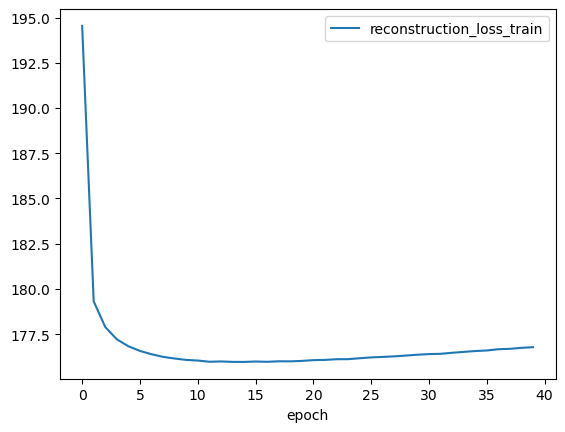

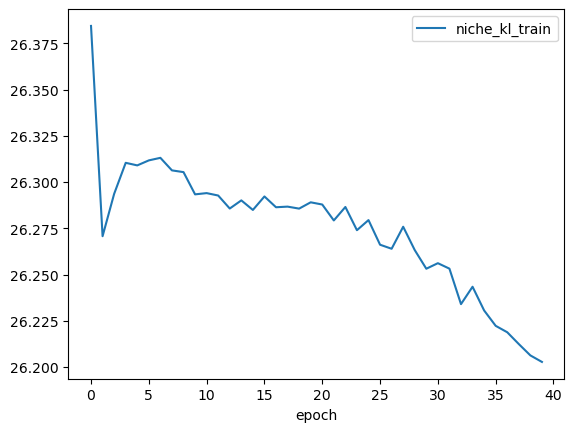

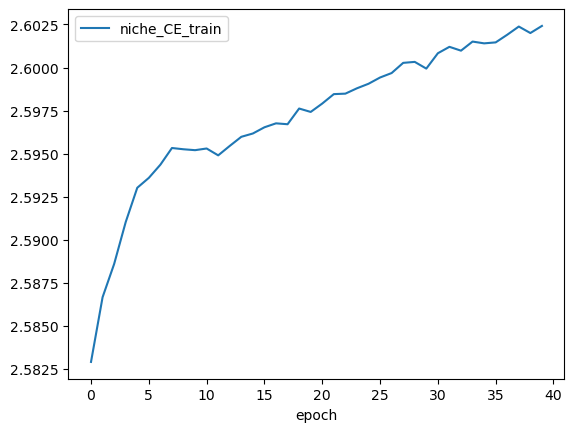

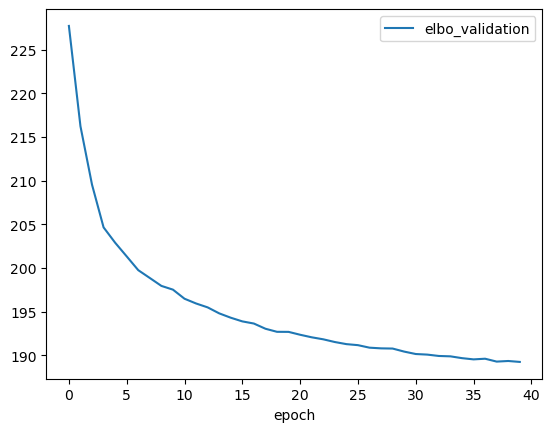

In [57]:
# nichevae.history["reconstruction_loss_train"].plot()
# nichevae.history["niche_kl_train"].plot()

# key = "mix_unif_kl0_compo0"
key = "mix_kl0_compo0"

history_setup[key]["reconstruction_loss_train"].plot()
history_setup[key]["niche_kl_train"].plot()
history_setup[key]["niche_CE_train"].plot()
history_setup[key]["elbo_validation"].plot()

<Axes: xlabel='epoch'>

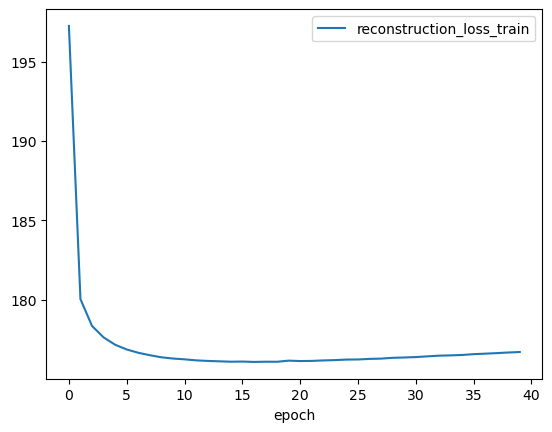

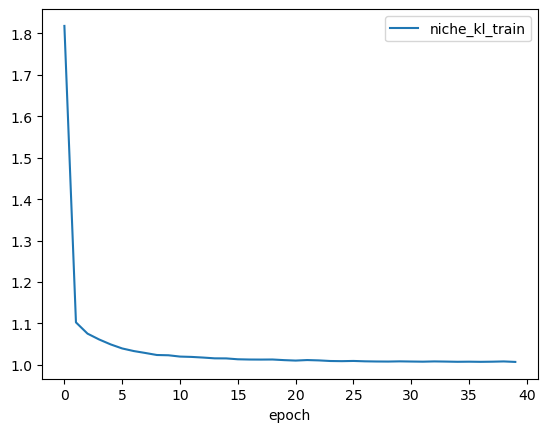

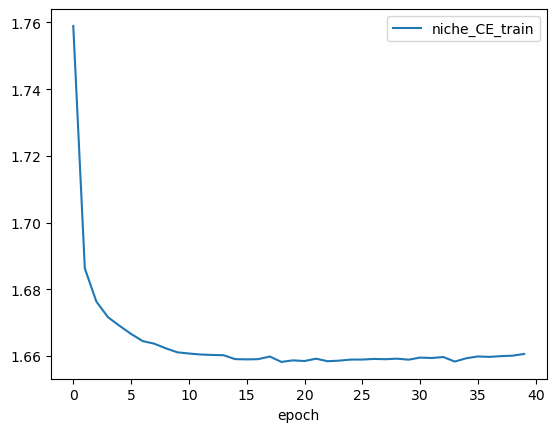

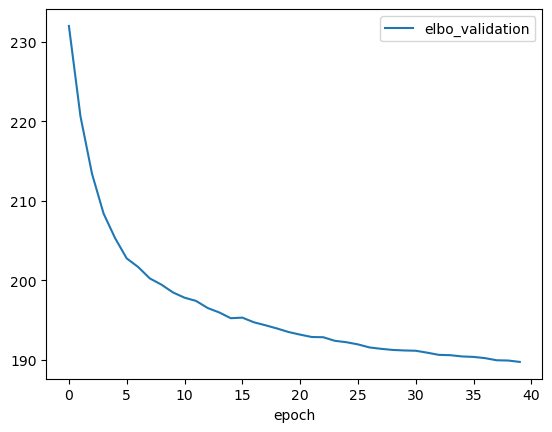

In [42]:
key = "mix_kl10_compo10"

history_setup[key]["reconstruction_loss_train"].plot()
history_setup[key]["niche_kl_train"].plot()
history_setup[key]["niche_CE_train"].plot()
history_setup[key]["elbo_validation"].plot()

In [39]:
# history_setup['cell_type_setup_mixture']['kl_local_train'].plot()

In [43]:
print(adata.obsm)

AxisArrays with keys: X_pca, X_scVI, X_spVI, X_spatial, X_umap, centroids, neighborhood_composition, spatial, 
qz1_m, qz1_var, niche_indexes, niche_distances, qz1_m_niche_ct, qz1_var_niche_ct, mix_kl50_compo50_X_nicheVI, 
mix_unif_kl50_compo50_X_nicheVI, mix_kl0_compo0_X_nicheVI, mix_unif_kl0_compo0_X_nicheVI, mix_kl1_compo1_X_nicheVI,
mix_unif_kl1_compo1_X_nicheVI, mix_kl10_compo10_X_nicheVI, mix_unif_kl10_compo10_X_nicheVI

/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


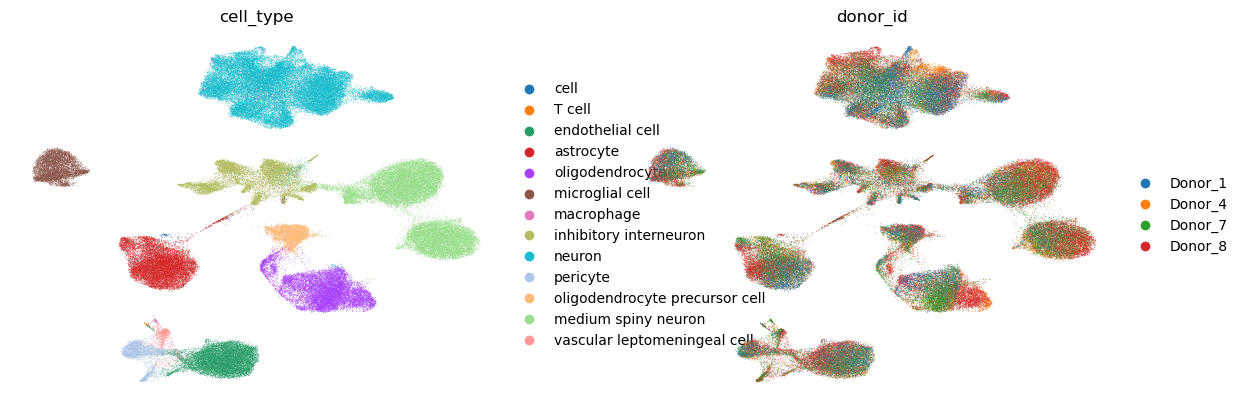

In [59]:
sc.pp.neighbors(adata, use_rep="mix_kl1_compo1_X_nicheVI")
sc.tl.umap(adata, min_dist=0.3)


sc.pl.umap(
    adata,
    color=["cell_type", "donor_id"],
    ncols=2,
    frameon=False,
)

## scib-metrics

In [44]:
adata.obsm["X_ldvae"] = adata.obsm["qz1_m"]
# adata.obsm["X_scVI"] = scvivae.get_latent_representation()

print(adata.obsm)

AxisArrays with keys: X_pca, X_scVI, X_spVI, X_spatial, X_umap, centroids, neighborhood_composition, spatial, 
qz1_m, qz1_var, niche_indexes, niche_distances, qz1_m_niche_ct, qz1_var_niche_ct, mix_kl50_compo50_X_nicheVI, 
mix_unif_kl50_compo50_X_nicheVI, mix_kl0_compo0_X_nicheVI, mix_unif_kl0_compo0_X_nicheVI, mix_kl1_compo1_X_nicheVI,
mix_unif_kl1_compo1_X_nicheVI, mix_kl10_compo10_X_nicheVI, mix_unif_kl10_compo10_X_nicheVI, X_ldvae

In [45]:
bm = Benchmarker(
    adata,
    batch_key="donor_slice",
    label_key="cell_type",
    embedding_obsm_keys=[
        "X_pca",
        "X_ldvae",
        "X_scVI",
        "mix_unif_kl10_compo10_X_nicheVI",
        "mix_kl10_compo10_X_nicheVI",
        "mix_unif_kl0_compo0_X_nicheVI",
        "mix_kl0_compo0_X_nicheVI",
        "mix_unif_kl1_compo1_X_nicheVI",
        "mix_kl1_compo1_X_nicheVI",
        "mix_unif_kl50_compo50_X_nicheVI",
        "mix_kl50_compo50_X_nicheVI",
    ], 
    n_jobs=-1,
)
bm.benchmark()

Embeddings:  91%|█████████ | 10/11 [57:19<05:36, 336.31s/it]

INFO     Diffusion distance failed. Skip.                                                                          


/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/scib_metrics/_pcr_comparison.py:49: UserWarning: PCR comparison score is negative, meaning variance contribution increased after integration. Setting to 0.
Embeddings: 100%|██████████| 11/11 [1:02:55<00:00, 343.20s/it]


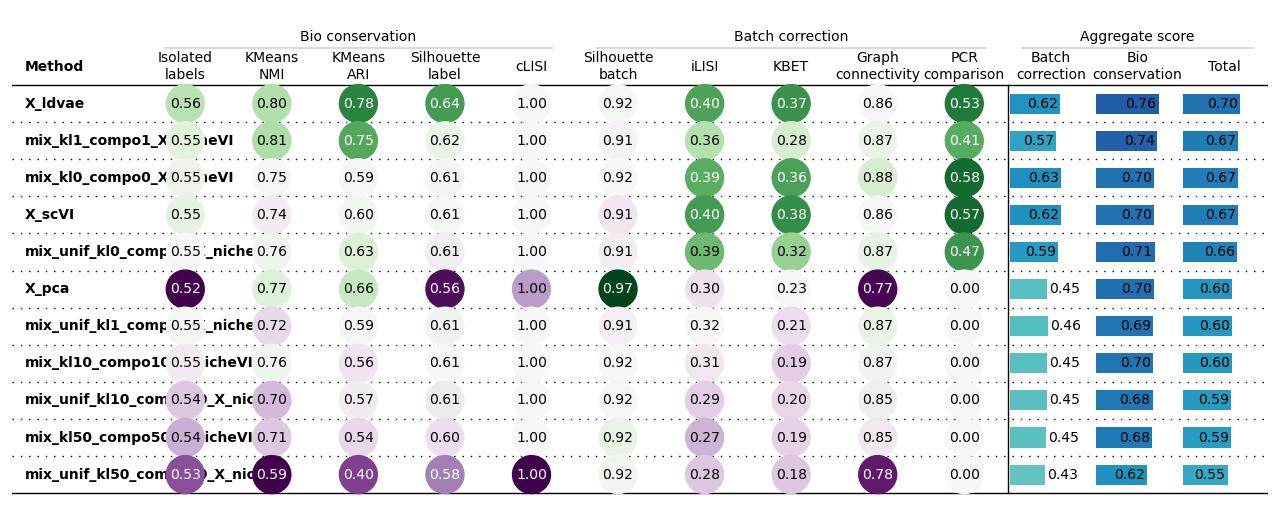

In [47]:
bm.plot_results_table(min_max_scale=False)

In [46]:
# df = bm.get_results(min_max_scale=False)
# print(df)

## spatial metrics

In [60]:
sa = SpatialAnalysis(
    adata=adata,
    label_key="cell_type",
    sample_key="donor_slice",
    latent_space_keys=[
        "X_ldvae",
        "X_scVI",
        # "mix_unif_kl10_compo10_X_nicheVI",
        "mix_kl10_compo10_X_nicheVI",
        # "mix_unif_kl0_compo0_X_nicheVI",
        "mix_kl0_compo0_X_nicheVI",
        # "mix_unif_kl1_compo1_X_nicheVI",
        "mix_kl1_compo1_X_nicheVI",
        # "mix_unif_kl50_compo50_X_nicheVI",
        "mix_kl50_compo50_X_nicheVI",
    ],
    spatial_coord_key="centroids",
    ct_composition_key="neighborhood_composition",
)

In [61]:
sa.compute_metrics(
    k_nn=40,  #what is the optimal k_nn?
    set_of_metrics=["distance", "similarity", "latent_overlap"],
    similarity_metric="spearman",
    reduction=["median", "mean"],
    z2_versus_z1=["X_scVI", "mix_kl50_compo50_X_nicheVI"],
)

X_ldvae

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [04:52<00:00, 29.24s/it]


The latent and physical correlation and neighborhood similarity are saved in the.obs columns: 
latent_and_phys_corr_X_ldvae and neighborhood_similarity_X_ldvae.

X_scVI

100%|██████████| 10/10 [04:48<00:00, 28.80s/it]


The latent and physical correlation and neighborhood similarity are saved in the.obs columns: 
latent_and_phys_corr_X_scVI and neighborhood_similarity_X_scVI.

mix_kl10_compo10_X_nicheVI

100%|██████████| 10/10 [04:47<00:00, 28.70s/it]


The latent and physical correlation and neighborhood similarity are saved in the.obs columns: 
latent_and_phys_corr_mix_kl10_compo10_X_nicheVI and neighborhood_similarity_mix_kl10_compo10_X_nicheVI.

mix_kl0_compo0_X_nicheVI

100%|██████████| 10/10 [04:53<00:00, 29.31s/it]


The latent and physical correlation and neighborhood similarity are saved in the.obs columns: 
latent_and_phys_corr_mix_kl0_compo0_X_nicheVI and neighborhood_similarity_mix_kl0_compo0_X_nicheVI.

mix_kl1_compo1_X_nicheVI

100%|██████████| 10/10 [04:51<00:00, 29.12s/it]


The latent and physical correlation and neighborhood similarity are saved in the.obs columns: 
latent_and_phys_corr_mix_kl1_compo1_X_nicheVI and neighborhood_similarity_mix_kl1_compo1_X_nicheVI.

mix_kl50_compo50_X_nicheVI

100%|██████████| 10/10 [04:53<00:00, 29.36s/it]


The latent and physical correlation and neighborhood similarity are saved in the.obs columns: 
latent_and_phys_corr_mix_kl50_compo50_X_nicheVI and neighborhood_similarity_mix_kl50_compo50_X_nicheVI.

The latent spaces overlap is saved in the.obs column: latent_overlap.

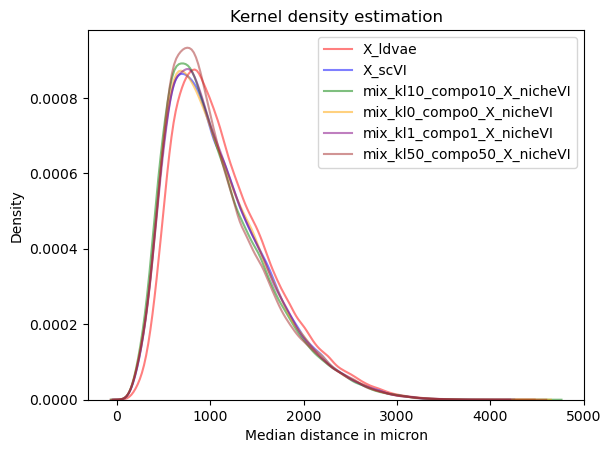

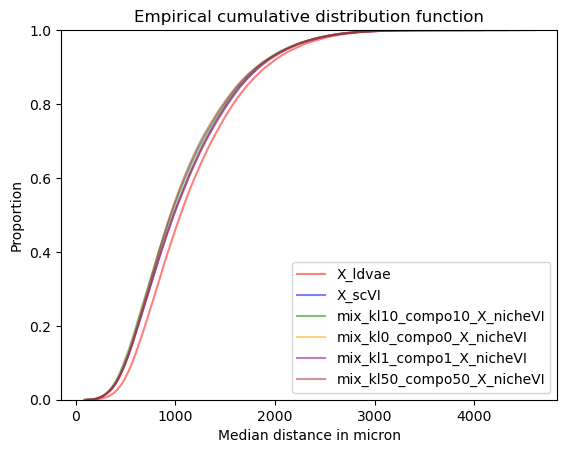

In [62]:
sa.plot_distance(plot_type='kde', split_by_key=None)
sa.plot_distance(plot_type="ecdf", split_by_key=None)

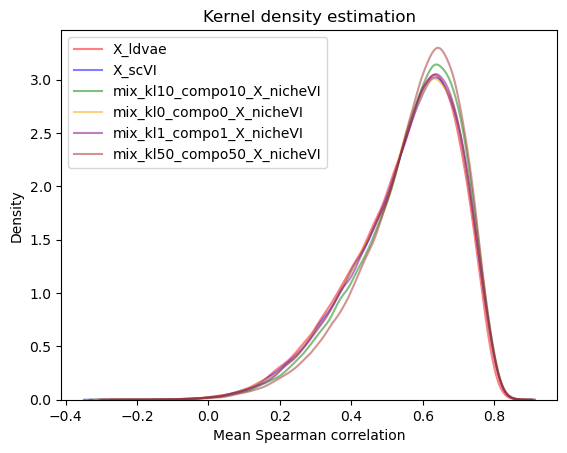

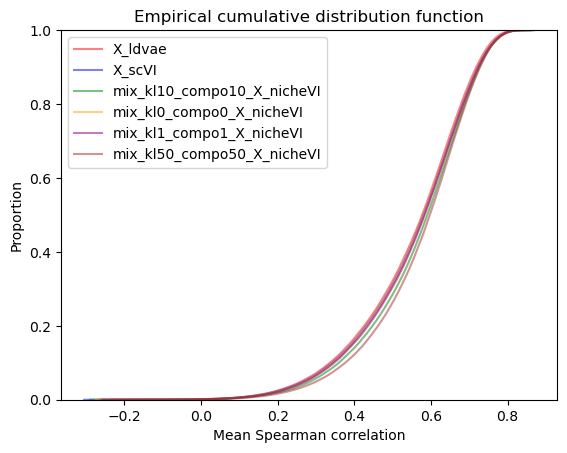

In [63]:
sa.plot_similarity(plot_type="kde")
sa.plot_similarity(plot_type="ecdf")

In [56]:
sa.get_latent_overlap()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Cell type                      ┃ #Cells ┃ Average Jaccard ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ endothelial cell               │ 11376  │ 0.12            │
│ oligodendrocyte precursor cell │ 4234   │ 0.15            │
│ neuron                         │ 34553  │ 0.13            │
│ astrocyte                      │ 12830  │ 0.12            │
│ inhibitory interneuron         │ 10330  │ 0.19            │
│ pericyte                       │ 3443   │ 0.23            │
│ oligodendrocyte                │ 13110  │ 0.15            │
│ microglial cell                │ 6317   │ 0.14            │
│ vascular leptomeningeal cell   │ 1137   │ 0.28            │
│ medium spiny neuron            │ 25667  │ 0.1             │
│ macrophage                     │ 355    │ 0.21            │
│ T cell                         │ 45     │ 0.17            │
│ cell                           │ 235    │ 0.17            │
└────────────────────────────────┴────────┴─────────────────┘

In [ ]:
# adata.write_h5ad("data/nicheVI.h5ad")

In [ ]:
adata = ad.read_h5ad("data/nicheVI.h5ad")

In [ ]:
print(adata)

AnnData object with n_obs × n_vars = 123632 × 374
    obs: 'fov', 'center_x', 'center_y', 'min_x', 'max_x', 'min_y', 'max_y', 'age', 'clust_annot', 'slice', 
'organism_ontology_term_id', 'sex_ontology_term_id', 'suspension_type', 'cell_type_ontology_term_id', 
'assay_ontology_term_id', 'tissue_ontology_term_id', 'disease_ontology_term_id', 
'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'donor_id', 'is_primary_data', 
'cell_type_annot', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 
'development_stage', 'donor_slice', 'n_counts', 'cell_index', '_scvi_batch', '_scvi_labels', 'index'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'cell_type_colors', 'donor_id_colors', 'log1p', 'neighbors', 'pca', 
'umap', 'qz1_m_niche_ct_prior', 'qz1_var_niche_ct_prior'
    obsm: 'X_pca', 'X_scVI', 'X_spVI', 'X_spatial', 'X_umap', 'centroids', 'neighborhood_composition', 'spatial', 
'qz1_m', 'qz1_var', 'niche_indexes', 'niche_distances', 'qz1_m_niche_knn', 'qz1_var_niche_knn', 'qz1_m_niche_ct', 
'qz1_var_niche_ct', 'X_nicheVI_cell_type_setup_mixture', 'X_nicheVI_cell_type_unweighted_setup_mixture', 'X_ldvae'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

## EXPERIMENTS